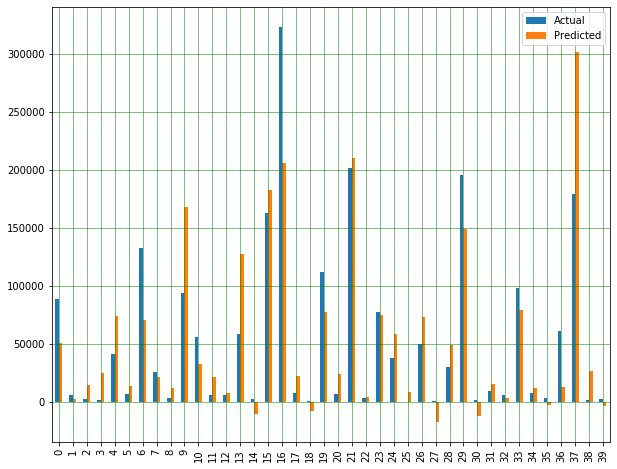

Linear Regression
Mean Absolute Error: 27662.973884344985
Mean Squared Error: 3010096599.865024
Root Mean Squared Error: 54864.34725634694

Gradient Boosting Regressor
Mean Absolute Error: 19238.526809543073
Mean Squared Error: 1945027057.5844972
Root Mean Squared Error: 44102.46090168322


In [4]:
%matplotlib inline
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

#To load Input data
dataset_test = pd.read_csv('tcd-ml-1920-group-income-train.csv')
#Renaming columns to remove space
dataset_test.columns = dataset_test.columns.str.strip().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
dataset_test.rename(columns={'Work_Experience_in_Current_Job_[years]': 'Work_Experience_in_Current_Job'}, inplace=True)
#Remove Instance Column
dataset_test = dataset_test.drop('Instance', 1)

#===========================================DATA CLEANING========================================================
#Change null to random value between std dev around mean. Alternate could be panda interpolate.
Column_Name_avg = dataset_test['Year_of_Record'].mean()
Column_Name_std = dataset_test['Year_of_Record'].std()
Column_Name_null_count = dataset_test['Year_of_Record'].isnull().sum()
Column_Name_null_random_list = np.random.randint(Column_Name_avg - Column_Name_std, Column_Name_avg + Column_Name_std, size=Column_Name_null_count)
dataset_test['Year_of_Record'][np.isnan(dataset_test['Year_of_Record'])] = Column_Name_null_random_list
dataset_test['Year_of_Record'] = dataset_test['Year_of_Record'].astype(int)

#Filling Gender Nan and other values
dataset_test.Gender = dataset_test.Gender.replace("f", "female")
dataset_test["Gender"].fillna("unknown", inplace = True)
dataset_test.Gender = dataset_test.Gender.replace("0", "unknown")

#Filling University Degree Nan Values
dataset_test.University_Degree = dataset_test.University_Degree.replace("0", "No")
dataset_test["University_Degree"].fillna("No", inplace = True)

#Filling Haircolor Nan Values
dataset_test.Hair_Color = dataset_test.Hair_Color.replace("0", "Unknown")
dataset_test["Hair_Color"].fillna("Unknown", inplace = True)
dataset_test = dataset_test.drop('Hair_Color', 1)

#Filling Profession Nan Values
dataset_test["Profession"].fillna("Unknown", inplace = True)

#Filling Housing_Situation Corrupt Values
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace(0,'Unknown')
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace('0','Unknown')
dataset_test["Housing_Situation"] = dataset_test["Housing_Situation"].replace('nA','Unknown')

#Forward fill for nan values
dataset_test['Satisfation_with_employer'] = dataset_test['Satisfation_with_employer'].fillna(method='ffill')
#===========================================END CLEANING========================================================

#=============================================DATA Preprocessing=================================================
#Convert work Experience in current job to float and replace #NUM! to mean of their Age
dataset_test.Work_Experience_in_Current_Job = dataset_test.Work_Experience_in_Current_Job.replace("#NUM!", None)
dataset_test['Work_Experience_in_Current_Job'] = dataset_test['Work_Experience_in_Current_Job'].astype(float)
dataset_test.value = dataset_test.groupby('Age')['Work_Experience_in_Current_Job'].apply(lambda x: x.fillna(x.median()))
dataset_test.value = dataset_test.Work_Experience_in_Current_Job.fillna(dataset_test.Work_Experience_in_Current_Job.median())

#Remove EUR in Yearly_Income to make it numerical value 
dataset_test['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'] = dataset_test['Yearly_Income_in_addition_to_Salary_e.g._Rental_Income'].replace('EUR', '', regex=True).astype(float)
dataset_test['Salary_by_Year'] = dataset_test.groupby('Year_of_Record')['Total_Yearly_Income_[EUR]'].transform('median')
dataset_test['Salary_by_Profession'] = dataset_test.groupby('Profession')['Total_Yearly_Income_[EUR]'].transform('mean')


#Binary Encoding Categorical Values
encoder = ce.BinaryEncoder(cols=['Profession'])
dataset_test = encoder.fit_transform(dataset_test)
encoder = ce.BinaryEncoder(cols=['Gender'])
dataset_test = encoder.fit_transform(dataset_test)
encoder = ce.BinaryEncoder(cols=['Housing_Situation'])
dataset_test = encoder.fit_transform(dataset_test)

#Label Encoding remaining categorical values
for col in dataset_test.dtypes[dataset_test.dtypes == 'object'].index.tolist():
    feat_le = LabelEncoder()
    feat_le.fit(dataset_test[col].unique().astype(str))
    dataset_test[col] = feat_le.transform(dataset_test[col].astype(str))

#Copied code from Hemlata
#this function takes a string column name and returns a list
#containing indices of dataframe that have outliers in that column
#Refer: https://towardsdatascience.com/5-ways-to-detect-outliers-that-every-data-scientist-should-know-python-code-70a54335a623
def OutlierByColumn(colname):
    rows = dataset_test.shape[0]
    col_std = np.std(dataset_test[colname])
    col_mean = np.mean(dataset_test[colname])
    anomaly_cut_off = col_std * 3
    lower_limit  = col_mean - anomaly_cut_off 
    upper_limit = col_mean + anomaly_cut_off
    anomalies_indices = []
    for i in range(rows):
        ele = dataset_test[colname][i]
        if ele > upper_limit or ele < lower_limit:
            anomalies_indices.append(i)
    return anomalies_indices

arr1 = OutlierByColumn('Work_Experience_in_Current_Job')
arr2 = OutlierByColumn('Age')
#arr3 = OutlierByColumn('Body_Height_[cm]')
arr4 = OutlierByColumn('Yearly_Income_in_addition_to_Salary_e.g._Rental_Income')
arr5 = OutlierByColumn('Size_of_City')
arr6 = OutlierByColumn('Salary_by_Year')
arr7 = OutlierByColumn('Salary_by_Profession')

#Union of all lists 
union_index = np.union1d(arr1,arr2)
#union_index = np.union1d(union_index,arr3)
union_index = np.union1d(union_index,arr4)
union_index = np.union1d(union_index,arr5)
union_index = np.union1d(union_index,arr6)
union_index = np.union1d(union_index,arr7)
len(union_index)
dataset_test = dataset_test.drop(union_index)
#============================================END Preprocessing=====================================================

#=================================================Final Prediction=================================================
#Divide data into X features and Y prediction columns
y = dataset_test['Total_Yearly_Income_[EUR]'].values
dataset_test.drop('Total_Yearly_Income_[EUR]', axis=1, inplace=True)
X = dataset_test[dataset_test.columns].values
#split 80% of the data to the training set while 20% of the data to test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)


#Train linear regression model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

#Doing prediction on test data
y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df.head(40)

#plot the comparison of Actual and Predicted values
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

print('Linear Regression')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


gbr = GradientBoostingRegressor()
gbr.fit(X_train,y_train)
y_pred = gbr.predict(X_test)
print('\nGradient Boosting Regressor')
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
